In [1]:
import sys
import pandas as pd
import ast
import pickle
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
import utils
import models
import dataset
import train_utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_utils.set_seed(42)

In [4]:
with open('../data/embeddings.pkl', 'rb') as f:
    node_features_df = pickle.load(f)

node_features_df['Concat Embedding'] = node_features_df['ESM Embedding'] + node_features_df['SubCell Embedding'] + node_features_df['PINNACLE Embedding']

train_df = pd.read_csv('../data/perturbation_screens/e_distance/train.csv')

train_dataset = dataset.MLPDataset(train_df.iloc[:int(0.9*len(train_df)), :], node_features_df, device=device)
val_dataset = dataset.MLPDataset(train_df.iloc[int(0.9*len(train_df)):, :], node_features_df, device=device)

input_dim = len(node_features_df['Concat Embedding'][0])

model = models.MLPClassifier(
    input_dim=input_dim,
    hidden_dim=256, 
    dropout_rate=0.25,
    neg_weight=3.0
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=dataset.collate_function_mlp)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate_function_mlp)

In [6]:
# Training loop across multiple epochs
num_epochs = 10
best_val_auc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    train_metrics = train_utils.train_one_epoch_mlp(model, train_loader, optimizer, device)
    val_metrics, y_true_val, y_pred_val, y_prob_val = train_utils.evaluate_mlp(model, val_loader, device)
    print([int(x) for x in y_true_val])
    print([int(x) for x in y_pred_val])

    # Save model if improved
    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        train_utils.save_model(model, '../models', experiment='test')
        print(f"New best model saved with AUC: {best_val_auc:.4f}")


===== Epoch 1/10 =====
[Batch 10] Loss: 0.4806
[Batch 20] Loss: 0.2043
[Batch 30] Loss: 0.4224
[Batch 40] Loss: 1.5006
[Batch 50] Loss: 1.4519
[Batch 60] Loss: 1.1263
[Batch 70] Loss: 0.9355
[Batch 80] Loss: 0.6360
[Batch 90] Loss: 0.6363
[Batch 100] Loss: 1.0218
[Batch 110] Loss: 0.9056
[Batch 120] Loss: 0.3577
[Batch 130] Loss: 0.7481
[Batch 140] Loss: 0.3873
[Batch 150] Loss: 0.1521
[Batch 160] Loss: 0.2198
[Batch 170] Loss: 0.5589
[Batch 180] Loss: 0.4579
[Batch 190] Loss: 0.6187
[Batch 200] Loss: 1.0358
[Batch 210] Loss: 0.7094
[Batch 220] Loss: 0.8366
[Batch 230] Loss: 0.7795
[Batch 240] Loss: 0.9724
[Batch 250] Loss: 0.8671
[Batch 260] Loss: 0.5665
[Batch 270] Loss: 0.3664
[Batch 280] Loss: 0.7866
[Batch 290] Loss: 0.4220
[Batch 300] Loss: 0.7913
[Batch 310] Loss: 2.6093
[Batch 320] Loss: 0.1189
[Batch 330] Loss: 0.3367
[Batch 340] Loss: 0.4141
[Batch 350] Loss: 1.4942

[Training] Loss: 0.8014 | Precision: 0.8834 | Recall: 0.7919 | F1: 0.8351 | AUC: 0.8062
Class distribution: 0

In [7]:
model = train_utils.load_model(model_class=models.MLPClassifier, input_dim=input_dim, hidden_dim=256, dropout_rate=0.25, neg_weight=3.0, path="../models/MLPClassifier/checkpoint_05_02-15_05.pt")

In [10]:
test_df = pd.read_csv('../data/perturbation_screens/e_distance/test.csv')

test_dataset = dataset.MLPDataset(test_df, node_features_df, device=device)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate_function_mlp)

In [11]:
test_metrics, y_true, y_pred, y_prob = train_utils.evaluate_mlp(model, test_loader, device)
print(test_metrics)


[Evaluation] Precision: 0.8446 | Recall: 0.5543 | F1: 0.6693 | AUC: 0.6496
Class distribution: 0 -> 188, 1 -> 608
{'precision': np.float64(0.8446115288220551), 'recall': np.float64(0.5542763157894737), 'f1': np.float64(0.6693147964250248), 'auc': np.float64(0.6496316839305711)}


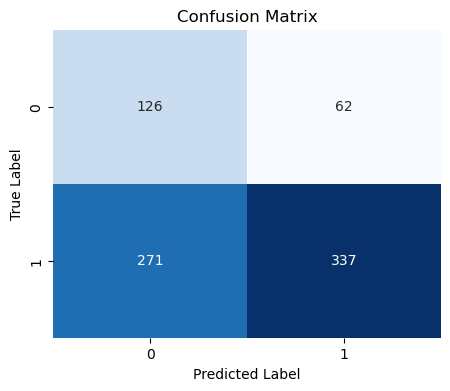

In [12]:
train_utils.plot_confusion_matrix(y_true, y_pred)

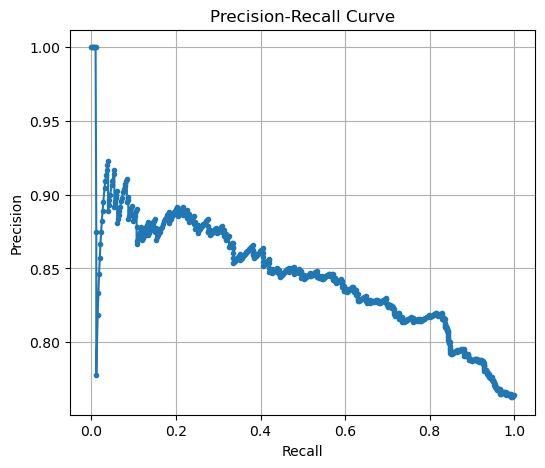

In [13]:
train_utils.plot_precision_recall(y_true, y_prob)

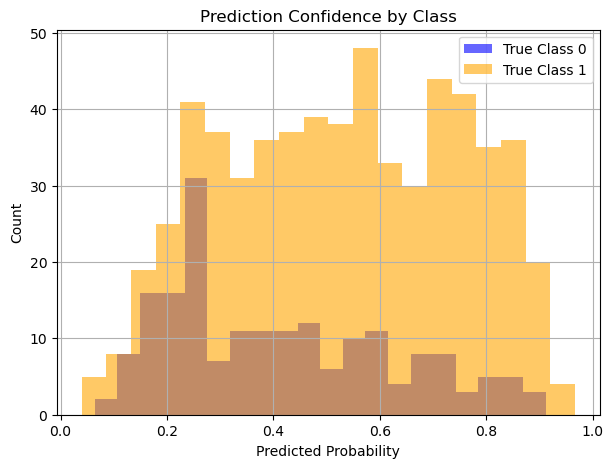

In [14]:
train_utils.plot_prediction_histograms(y_true, y_prob)